In [8]:
import numpy as np 
import gymnasium as gym 
import matplotlib.pyplot as plt
from collections import defaultdict

In [13]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
gamma = 0.9  
episodes = 50000  
returns_sum = defaultdict(float)  
returns_count = defaultdict(int)
V = defaultdict(float)

#Monte-Carlo Prediction
for episode in range(episodes):
    initial_state = env.reset()
    state = initial_state if isinstance(initial_state, int) else initial_state[0]
    episode_data = []
    done = False

    while not done:
        action = env.action_space.sample()  # Random policy
        next_state, reward, done, _ , _ = env.step(action)
        
        state = int(state) if not isinstance(state, int) else state
        next_state = int(next_state) if not isinstance(next_state, int) else next_state

        episode_data.append((state, reward))
        state = next_state

    G = 0
    iter = 0

    for state, reward in reversed(episode_data):
        state = int(state)  
        G += gamma**iter * reward
        iter += 1
        returns_sum[state] += G
        returns_count[state] += 1
        V[state] = returns_sum[state] / returns_count[state]

for state in range(env.observation_space.n):
    print(f"State {state}: Value = {V[state]:.6f}")

State 0: Value = 0.014688
State 1: Value = 0.012236
State 2: Value = 0.023935
State 3: Value = 0.011981
State 4: Value = 0.017694
State 5: Value = 0.000000
State 6: Value = 0.048255
State 7: Value = 0.000000
State 8: Value = 0.036748
State 9: Value = 0.094075
State 10: Value = 0.165128
State 11: Value = 0.000000
State 12: Value = 0.000000
State 13: Value = 0.191653
State 14: Value = 0.477785
State 15: Value = 0.000000


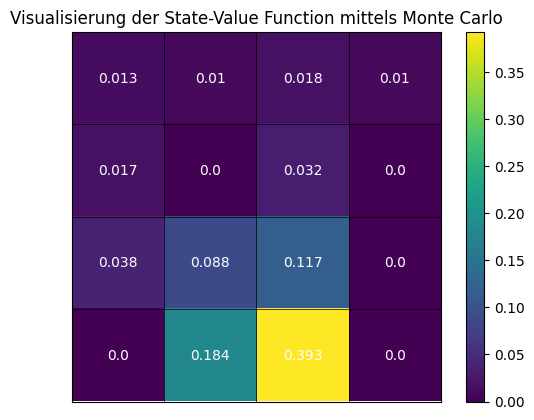

In [10]:
def visualize_state_value_function(state_values): 
    matrix = np.round(state_values, 3)

    # Erstelle die Grafik
    fig, ax = plt.subplots()

    # Zeige die Matrix als Bild mit Ursprung oben links
    cax = ax.imshow(matrix, cmap='viridis', origin='upper')

    # Füge Text für jeden Wert in das Raster
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(j, i, matrix[i, j], ha='center', va='center', color='white')

    # Zeige die Farbskala und das Raster
    plt.colorbar(cax)
    plt.grid(visible=True, color='black', linestyle='-', linewidth=0.5)

    # Anpassung der Achsen
    ax.set_xticks(np.arange(-0.5, 4, 1))
    ax.set_yticks(np.arange(-0.5, 4, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(f"Visualisierung der State-Value Function mittels Monte Carlo")
    ax.tick_params(length=0)  # Entfernt die kleinen Ticks auf den Achsen

    # Rasterlinien aktivieren
    plt.grid(True)
    plt.show()

V_matrix = np.zeros((4, 4))
for state in range(env.observation_space.n):
    row = state // 4
    col = state % 4
    V_matrix[row, col] = V[state]

visualize_state_value_function(V_matrix)

In [ ]:
epsilon = 0.3
gamma = 0.9  
episodes = 50000  

Q = defaultdict(lambda: np.zeros(env.action_space.n))  # Action-value function
policy = defaultdict(lambda: np.ones(env.action_space.n) / env.action_space.n)  # Uniform initial policy

# Tracking returns for Q(s, a)
returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
returns_count = defaultdict(lambda: np.zeros(env.action_space.n))

for episode in range(episodes):

    state = env.reset() if isinstance(env.reset(), int) else env.reset()[0]
    episode_data = []
    done = False

    while not done:

        if episode == 0: 
            action = env.action_space.sample()
        else: 
            if np.random.rand() < epsilon:
                action = np.argmax(policy[state])
            else: 
                action = env.action_space.sample()

        next_state, reward, done, _, _ = env.step(action)
        episode_data.append((state, action, reward))
        state = next_state

    # Process episode and update Q(s, a)
    G = 0
    visited_state_action_pairs = set()
    iter = 0 

    for state, action, reward in reversed(episode_data):

        if (state, action) not in visited_state_action_pairs:
            
            G += gamma**iter * reward
            iter += 1

            visited_state_action_pairs.add((state, action))
            returns_sum[state][action] += G
            returns_count[state][action] += 1

            Q[state][action] = returns_sum[state][action] / returns_count[state][action]
            best_action = np.where(Q[state] == np.max(Q[state]))[0]
            policy[state] += np.ones(env.action_space.n) / env.action_space.n
            policy[state][best_action] += 1/len(best_action)

# 4. Output the optimal policy
print("Optimal Policy (0 = Left, 1 = Down, 2 = Right, 3 = Up):")
optimal_policy = np.zeros((4, 4), dtype=int)

for state in range(env.observation_space.n):
    row = state // 4
    col = state % 4
    optimal_policy[row, col] = np.argmax(Q[state])

print(optimal_policy)

# 5. Optional: Output Action-Value Function (Q-table) huhu 
print("\nAction-Value Function (Q[s, a]):")
for state in range(env.observation_space.n):
    print(f"State {state}: {Q[state]}")

Optimal Policy (0 = Left, 1 = Down, 2 = Right, 3 = Up):
[[0 3 2 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]

Action-Value Function (Q[s, a]):
State 0: [0.03663408 0.03422964 0.03247749 0.03185386]
State 1: [0.02219792 0.02517    0.02279234 0.03478767]
State 2: [0.04357082 0.03917568 0.04536917 0.03104213]
State 3: [0.02068662 0.02445448 0.01513718 0.03462687]
State 4: [0.04650953 0.03467314 0.0332148  0.02267206]
State 5: [0. 0. 0. 0.]
State 6: [0.0761808  0.05918682 0.08121393 0.0136197 ]
State 7: [0. 0. 0. 0.]
State 8: [0.03441156 0.07566012 0.05811333 0.08144285]
State 9: [0.10339321 0.16666667 0.15426209 0.09685134]
State 10: [0.23905401 0.21789883 0.17945205 0.07020057]
State 11: [0. 0. 0. 0.]
State 12: [0. 0. 0. 0.]
State 13: [0.12572856 0.23862661 0.30419162 0.22698908]
State 14: [0.31590414 0.58349609 0.57242063 0.45362903]
State 15: [0. 0. 0. 0.]
